In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib #웹에서 데이터를 다운로드 할 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 준비한 이미지를 읽습니다.
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(575, 487, 3)


### 배경에만 렌즈 흐림 효과를 주기 위해서 이미지에서 사람과 피사체를 분리해야 합니다.

- 세그멘테이션(segmentation): 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법. 모든 픽셀에 라벨을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 이 '공통적인 특징'은 물리적 의미가 있을수도 없을수도 있습니다. 픽셀이 비슷하다는것은 인식하지만, 사람이 실체 물체 단위로 인식을 하는것처럼은 하지 못할수도 있다는 것 입니다.


- 시멘틱 세그멘테이션(semantic segmentation): 세그멘테이션 중에서도 사람이 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 말합니다. 예를 들자면, 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류하는 방법이라고 보면 됩니다.


- 인스턴스 세그멘테이션(instance segmentation): '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법 입니다. 사람이 누구이던지 상관없이 같은 라벨로 표시가 됩니다. 또한 인스턴스 세그멘테이션은 개개인별로 다른 라벨을 가지게 합니다.여러 사람이 한 이미지에 등장할 때 각 개체를 분할해서 인식하자는 것이 목표입니다.


- 워터쉐드 세그멘테이션(watershed segmentation): 물체의 '경계'를 나누는 것입니다. 이미지를 그레이스케일로 변환하면 0에서 255의 값을 가지게 되는데 이를 통 해 각 위치의 높고 낮음을 구분할 수 있습니다. 낮은 부분부터 '물'을 채워나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 발생하게 됩니다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다. 이 방법은 딥러닝에 기반한 방법 이전에 사용되던 이미지 세그멘테이션 방법입니다.

In [3]:
# 사용할 세그멘테이션 모델은 DeepLab 알고리즘(DeepLab v3+). 성능이 좋아 지금도 사용하는 모델.

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수입니다. 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리 합니다. 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정합니다. 전처리된 이미지는 run() 함수에서 입력값으로 사용되는 것을 볼 수 있습니다.

Aiffel의 딥러닝 관련 코드는 tf v2기준으로 작성이 되지만, 이번 노드에서는 tf v1 기준으로 만들어진 모델을 가져와 활용합니다. 따라서, tf v2에서 v1의 코드와 모델 구조를 활용할 수 있게 만들어 주는 tf.compat.v1를 활용해서 session, graph, feed_dict등 v2에서는 model, input에 감추어져 있는 구조가 위 코드에 들어나 있습니다.


In [4]:
# 사전에 학습된 가중치를 불러옵니다.
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 하고 DeepLabModel을 초기화 합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3버전 입니다.

In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(575, 487, 3) (513, 434, 3) 15


img_orig의 크기는 575x487이고 img_resized의 크기는 513x434 입니다. 세그멘티이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max()는 15라는 값이 출력됩니다. 이건 무슨뜻 일까요?

In [6]:
# deeplab은 pascal voc의 라벨로 학습되었습니다. 제공하는 라벨의 종류는 아래와 같습니다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20의 의미는 tv가 되겠습니다. 우리는 이중 person 라벨, 즉 15를 가진영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화를 해줍니다.

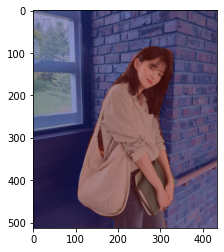

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 15를 제외한 나머지 예측은 0으로 만들어 줍니다. 그럼 예측된 세그멘테이션 이미지(map)는 최대값이 15가 됩니다. 일반 이미지는 0부터 255까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 시킵니다. applyColorMap()함수로 색을 적용하고 이미지를 화면에 출력해줍니다.

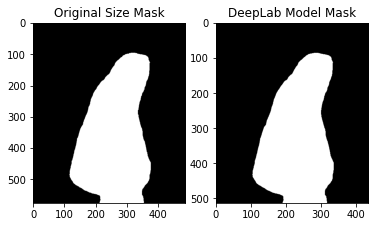

In [8]:
# deeplab모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력으로 넣었기 때문에, 출력도 resize된 값으로 나옵니다.
# 세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

cv2.resize()함수를 이용하는데, 크기를 키울 때 보간(interpolation)을 고려해야 합니다. cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR를 사용합니다. 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법입니다.

결과적으로 img_mask_up은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128이하의 값은 0으로 128이상의 값은 255로 만드는 방법입니다.

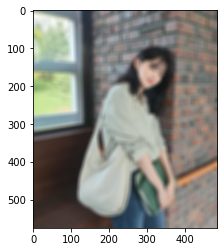

In [9]:
# 배경을 흐리게 만들기 위해서 blur()함수를 이용
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

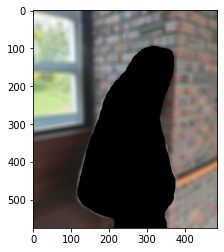

In [10]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출합니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not함수를 이용하면 이미지가 반전됩니다. 배경은 255 사람은 0이 됩니다. 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

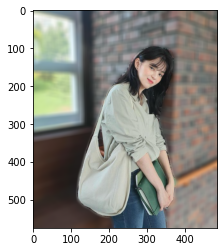

In [11]:
# 배경영상과 사람영상을 합치면 됩니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다.

# project

## 1. 인물모드 직접 해보기

- 다른 사진으로 해보기(사람, 고양이)
- 배경을 blur 이외에 다른 사진으로 대체

In [12]:
# 내 얼굴 사진을 불러옵니다.
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_face.jpeg'
img_orig = cv2.imread(img_path) 
print ('success!',img_orig.shape)

success! (750, 750, 3)


In [13]:
# 이미 정의된 모델과 가중치를 사용합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(750, 750, 3) (513, 513, 3) 15


입력된 사진은 사람이기 때문에 알맞는 label값인 15가 나와야 합니다.

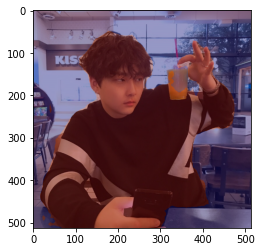

In [14]:
# '나'만 추출합니다
img_show = img_resized.copy()

# 예측 중 사람만 추출(=15)
seg_map = np.where(seg_map == 15, 15, 0)

# 정규화(세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 가중치 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

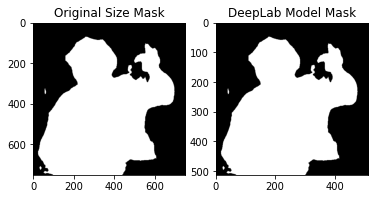

In [15]:
# 모델에 넣기 위해 작게 만든 사이즈를 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 나는 검은색으로 표현. bitwise를 이용해서 이미지를 반전시킴(label이 15인 부분을 0으로)
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

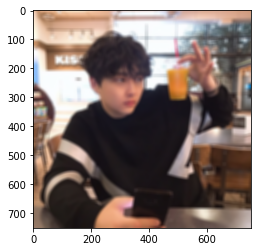

In [16]:
# 배경을 흐리게 만들기 위해서 blur()함수를 이용
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

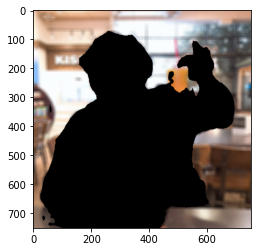

In [17]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출합니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

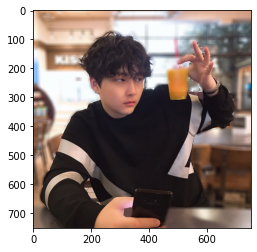

In [18]:
# 배경영상과 사람영상을 합치면 됩니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
# 고양이 사진
import os
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
catPic = cv2.imread(cat_path) 
print ('success!',catPic.shape)

success! (481, 658, 3)


In [27]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
#고양이는 8번

In [28]:
#불러온 사진을 리사이징하고, 미리 훈련된 모델에 적용해보자
resizedPic, seg_map = MODEL.run(catPic)

print (catPic.shape, resizedPic.shape, seg_map.max())

(481, 658, 3) (375, 513, 3) 16


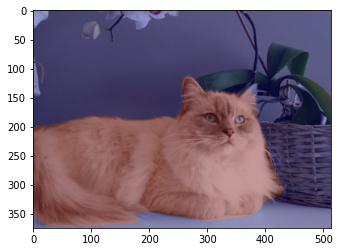

In [29]:
#위의 라벨에 따라 8번 필터(고양이)를 적용해준다.
img_show = resizedPic.copy()

#cat은 8번
seg_map = np.where(seg_map == 8, 8, 0)

#정규화
#세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

#가중치 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

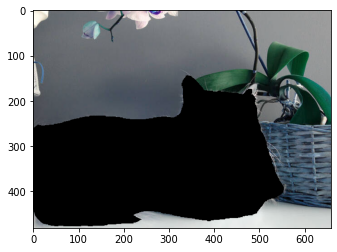

In [30]:
#모델에 넣기 위해 작게 만든 사이즈를 복원한다
img_mask_up = cv2.resize(img_mask,  catPic.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#bitwise를 이용하여 이미지를 반전시킴
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(catPic, img_bg_mask)
plt.imshow(img_bg)
plt.show()

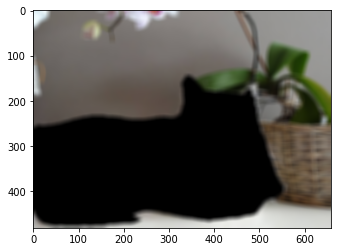

In [31]:
#배경을 블러 처리하기
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

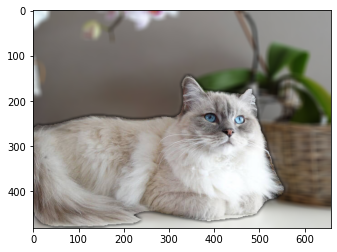

In [32]:
img_concat = np.where(img_mask_color==255, catPic, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

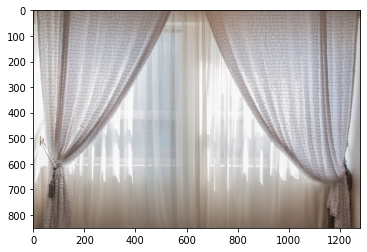

In [33]:
# 배경합성
back_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'
back_orig = cv2.imread(back_path)
plt.imshow(cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB))
plt.show()

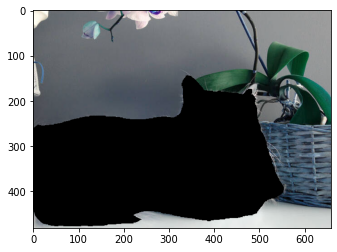

In [34]:
# 배경과 고양이를 합성하기 위해서는 먼저 고양이를 비트계산을 해서 검은색으로 만들어 주어야 합니다.

# 이미지 로드
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
catPic = cv2.imread(cat_path) 

# 리사이징과 모델 적용
resizedPic, seg_map = MODEL.run(catPic)

img_show = resizedPic.copy()

# 필터 지정
seg_map = np.where(seg_map == 8, 8, 0)

img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 가중치
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#사이즈 복원
img_mask_up = cv2.resize(img_mask,  catPic.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(catPic, img_bg_mask)
plt.imshow(img_bg)
plt.show()

In [35]:
#같이 합성하려면 배경 사이즈를 고양이 사진에 맞춰줘야 한다.
print('고양이 사진 크기 : ', catPic.shape)
print('배경 사진 크기 : ', back_orig.shape)

고양이 사진 크기 :  (481, 658, 3)
배경 사진 크기 :  (851, 1280, 3)


In [36]:
#배경 사진 크기를 고양이 사진 크기와 같이 조정해준다.
back_resize = cv2.resize(back_orig, catPic.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

In [37]:
print('리사이징한 배경 사진 크기 : ', back_resize.shape)

리사이징한 배경 사진 크기 :  (481, 658, 3)


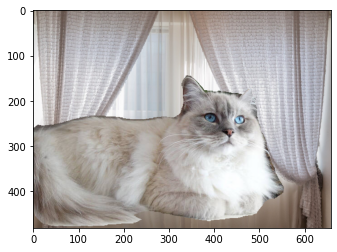

In [38]:
#같이 합성하려면 배경 사이즈를 고양이 사진에 맞춰줘야 한다.
img_concat = np.where(img_mask_color==255, catPic, back_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 사진의 문제점 찾기

- 제 사진이나 고양이 사진이나 전체적으로는 세그먼트가 잘 된거 같습니다. 단지 조그마한 부분이 조금 아쉬웠습니다. 제 사진같은 경우, 음료수를 들고있는 부분이 확실히 '사람'으로 인식되지 않아서 배경과 같이 블러처리가 되었습니다. 이걸 정확하게 한거라고 해야할지 아님 잘못 되었다고 해야할지 애매한거 같습니다. 당연히 음료수는 사람이 아니기에 레이블이 15가 아니가 됩니다. 다만 우리의 목표는 음료수를 들고있는 나를 명확하게 표현해야 하는것 이므로 컴퓨터는 일을 잘 한거 같은데 목표에는 어긋났습니다. 고양이 사진같은 경우 왼쪽 귀 끝부분이 같이 블러처리가 된걸 보실수 있습니다 (문제가 되는 부분을 하이라이트 해서 올리려고 하는데 안올려지네요;; 이미지가 너무 작아서 그런가요?ㅜㅜ). 또한 고양이 털 주변으로 두루뭉실하게?! 라인이 잡혀있는것을 볼 수 있습니다. 이는 예상컨데 고양이의 털들이 삐쭉삐쭉?!?! 하게 솟아 있기때문에 이 털들을 하나하나 잡기에는 너무 많은 자원이 필요하고 너무 미세한 차이라서 스킵해 버린게 아닌가 싶습니다. 특히 귀같은 경우에는 솔직히 잘 모르겠습니다. 왜 귀의 일정 부분만 제대로 표현이 되었는지 잘 이해가 안갑니다. 오른쪽 귀에 살짝 어두운 부분이 배경의 어두운 부분과 같다 라고 판단을 해서 이런 결과가 나온게 아닌가 싶기도 합니다.

# 3. 해결 방법 제안해 보기

- 문제점을 크게 2가지로 나눌수 있겠습니다.
    1. 원하지 않는 부분에 세그멘테이션이 되는 문제
    2. 이미지를 합성할 때 테두리 부분에 선이 존재하는것.

### [1] 

정확히 픽셀단위로 원하는 부분을 선택하게 하면 방법이야 있겠지만 앞서 이야기 드린대로 너무 많은 자원이 필요해서 그닥 유용한 방법은 아닌거 같습니다. 그래서 생각해낸 것이 뚜렷히 보여주고 싶은 이미지의 밝기? 색온도? 등등을 조정해서 주변 배경과의 차별점을 주어 뚜렷히 고양이만을 보여줄 수 있는 방법이 있을거 같습니다. 예를들자면, 고양이 부분의 평균적인 색과 밝기 그리고 온도등을 값으로 내어 급격하게 색, 밝기 그리고 온도등이 바뀌는 지점을 배경과 인접한 부분으로 지정하고 세그멘테이션을 진행하게 되면 더욱 선명하게 고양이 만을 보여줄 수 있지 않을까 싶습니다.

### [2]

아무래도 서로 다른 이미지 2개를 합성하다 보니 생기는 현상 같습니다. 이는 예상컨데 고양이사진의 세그멘테이션 마스크 부분에서 다른 사진과 합성이 될 때, 컴퓨터는 합성된 하나의 사진이 아닌 두개의 다른 사진이 한곳에 포개어져 있다고 인식이 되어서 그런거 같습니다. 따라서 고양이를 나타내는 부분의 최말단 부분 (마스크의 끝부분)이 고양이 사진과 배경사진이 서로 구분됨을 나타내 주기 위해 생긴 현상 같습니다. 이를 해결해 주기 위해서는 이미지의 깊이를 표현해 줄 수 있는 struct2Depth를 사용해서 각 이미지의 깊이를 표현해 주고 배경 사진의 깊이를 극단적으로 조정해 주면 고양이 사진과 배경 사진을 하나로 포갤수 있고, 이후 후처리로 워터쉐드 세그멘테이션 방법을 사용해 주면 하나의 이미지로 인식이 될 수 있는 여지가 생기지 않을까요...?

# 회고

https://github.com/JeongeunJPark/AIFFEL_EX10_ShallowFocus/blob/master/Exploration%2010_인물%20사진을%20만들어보자!.ipynb 의 github을 참고해서 프로젝트를 진행했습니다.

노드를 하면서 배우고 있지만 이미지 처리를 위한 방법은 끝이 없는거 같습니다. 앞으로 나올 신기술들을 생각하면 공부에는 끝이 없네용... 아직 코드를 보는 눈이 없어서 코드 한줄한줄이 어떤 역할을 하는지는 모르지만, 문제 해결 방법의 흐름을 파악하게 되어서 값졌습니다. 다만 해결 방법 제안하는 부분에서 제 머리속에서 검증도 안거친 생각들을 막 써놔서 두서 없고 근거 없는 말들이었는데 조금이라도 생각해 볼 여지가 생기는 글이었다면 제 자신이 조금 자랑스러워질거 같습니다 ㅎㅎㅎㅎ 점점 나아지고 있는 모습을 보고 있습니다. 전에는 그냥 무지성 복붙이었다면, 이제는 생각을 하게 되는 성숙한 학생이 되었답니다. 이걸 응용할수 있는 능력이 있어야 하는데 거기까지는 아직 멀고도 멀었습니다. 빨리 그 날이 오기를 간절히 바랍니다.